In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import MinMaxScaler

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

## Load Training and Testing Data

In [3]:
(df, train_df, test_df, feature_names, next_two_weeks) = get_features_and_data()

training examples = 2500, testing examples = 327


In [4]:
train_df = train_df[train_df["year"] >= 2022].copy()
df = df[df["year"] >= 2022].copy()

In [5]:
scaler = MinMaxScaler().fit(train_df[["days_since_previous_release", "days_until_next_holiday"]])
train_df[["days_since_previous_release", "days_until_next_holiday"]] = scaler.transform(
    train_df[["days_since_previous_release", "days_until_next_holiday"]])
test_df[["days_since_previous_release", "days_until_next_holiday"]] = scaler.transform(
    test_df[["days_since_previous_release", "days_until_next_holiday"]])

In [6]:
scaler = MinMaxScaler().fit(df[["days_since_previous_release", "days_until_next_holiday"]])
df[["days_since_previous_release", "days_until_next_holiday"]] = scaler.transform(
    df[["days_since_previous_release", "days_until_next_holiday"]])
next_two_weeks[["days_since_previous_release", "days_until_next_holiday"]] = scaler.transform(
    next_two_weeks[["days_since_previous_release", "days_until_next_holiday"]])

## Model-Building and Evaluation

In [7]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=train_df["prob_of_release"],
                       lower=0, upper=1, shape=features.shape[1])

In [8]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [9]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.80,0.04,0.72,0.87,0.0,0.0,3073.50,2764.47,1.0
WD_Tuesday,0.14,0.02,0.10,0.18,0.0,0.0,2072.78,2569.48,1.0
WD_Monday,0.12,0.02,0.08,0.16,0.0,0.0,1952.27,2878.75,1.0
WD_Wednesday,0.12,0.02,0.08,0.16,0.0,0.0,2078.81,2520.03,1.0
WD_Thursday,0.08,0.02,0.04,0.12,0.0,0.0,2078.94,2830.30,1.0
WD_Sunday,0.06,0.02,0.02,0.10,0.0,0.0,1952.19,2486.41,1.0
WD_Saturday,0.01,0.02,-0.03,0.05,0.0,0.0,2057.52,2712.37,1.0
days_until_next_holiday,0.00,0.02,-0.04,0.05,0.0,0.0,3814.86,2710.14,1.0
previous_release_preorder,-0.01,0.03,-0.08,0.05,0.0,0.0,3730.21,2876.05,1.0


In [10]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.27,0.02,0.23,0.30,0.0,0.0,1697.01,2444.55,1.0
error,0.14,0.00,0.13,0.15,0.0,0.0,3307.15,3030.28,1.0


### Out-of-Sample Evaluation

In [11]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [12]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [13]:
mape(test_df["prob_of_release"], y_pred)

0.23538130615091846

In [14]:
wape(test_df["prob_of_release"], y_pred)

0.20224849536689649

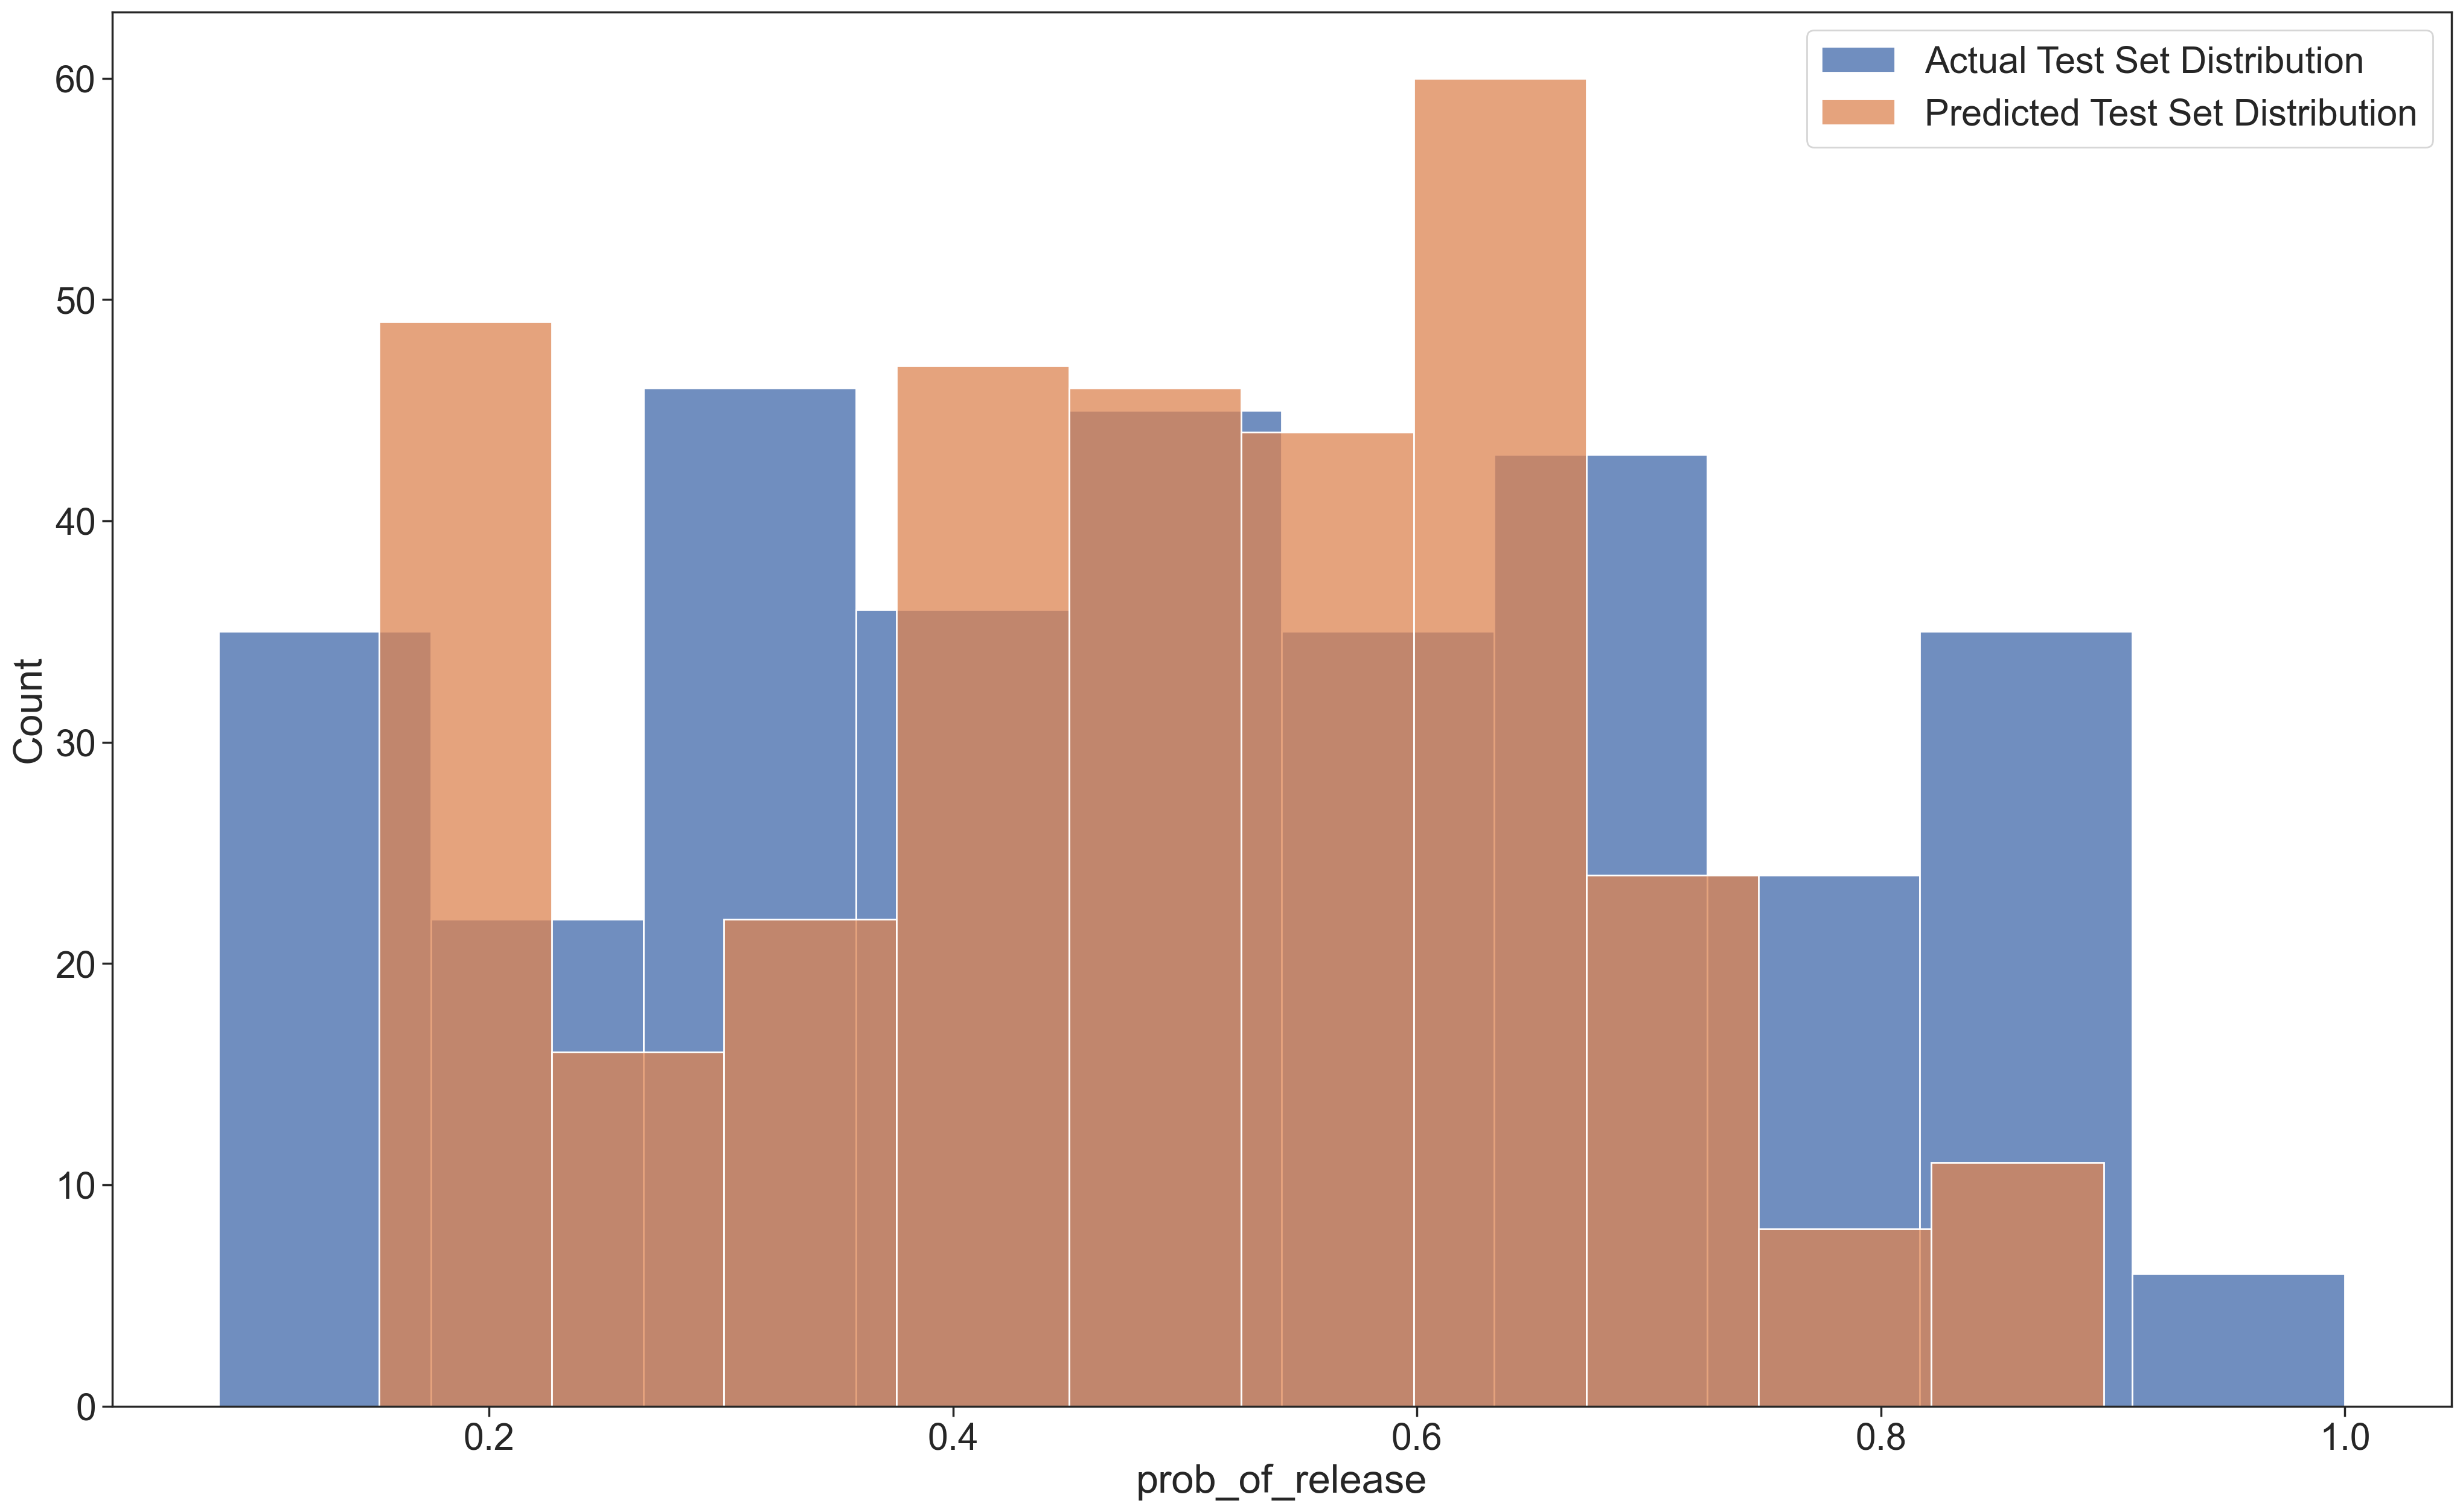

In [15]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=y_pred, ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Two Weeks

In [16]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [17]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [18]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.77,0.03,0.70,0.83,0.0,0.0,3357.42,2916.26,1.0
WD_Tuesday,0.15,0.02,0.12,0.19,0.0,0.0,2328.29,2447.93,1.0
WD_Wednesday,0.14,0.02,0.10,0.17,0.0,0.0,2298.67,2933.68,1.0
WD_Monday,0.12,0.02,0.09,0.16,0.0,0.0,2047.06,2732.03,1.0
WD_Thursday,0.10,0.02,0.07,0.13,0.0,0.0,2296.44,2679.54,1.0
WD_Sunday,0.06,0.02,0.03,0.09,0.0,0.0,2245.86,2380.79,1.0
WD_Saturday,0.02,0.02,-0.02,0.05,0.0,0.0,2201.15,2639.13,1.0
days_until_next_holiday,0.00,0.02,-0.04,0.04,0.0,0.0,4215.40,2710.74,1.0
previous_release_preorder,-0.01,0.03,-0.06,0.04,0.0,0.0,3146.49,3134.72,1.0


In [19]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.27,0.02,0.24,0.30,0.0,0.0,1784.62,2157.70,1.0
error,0.14,0.00,0.14,0.15,0.0,0.0,4037.37,2832.73,1.0


In [20]:
with model:
    pm.set_data({"features" : next_two_weeks[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [21]:
next_two_weeks["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [22]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_two_weeks["predicted_min"] = hdi["y_pred"][:, 0]
next_two_weeks["predicted_max"] = hdi["y_pred"][:, 1]

In [23]:
next_two_weeks[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
0,2024-11-25,0.2299,0.5060,0.7834
1,2024-11-26,0.3307,0.5906,0.8816
2,2024-11-27,0.3615,0.6316,0.9091
3,2024-11-28,0.4083,0.6549,0.9478
4,2024-11-29,0.3431,0.6149,0.9032
5,2024-11-30,0.4175,0.6863,0.9475
6,2024-12-01,0.5518,0.7765,0.9984
7,2024-12-02,0.6467,0.8478,1.0000
8,2024-12-03,0.7212,0.8869,1.0000
9,2024-12-04,0.7470,0.9020,1.0000


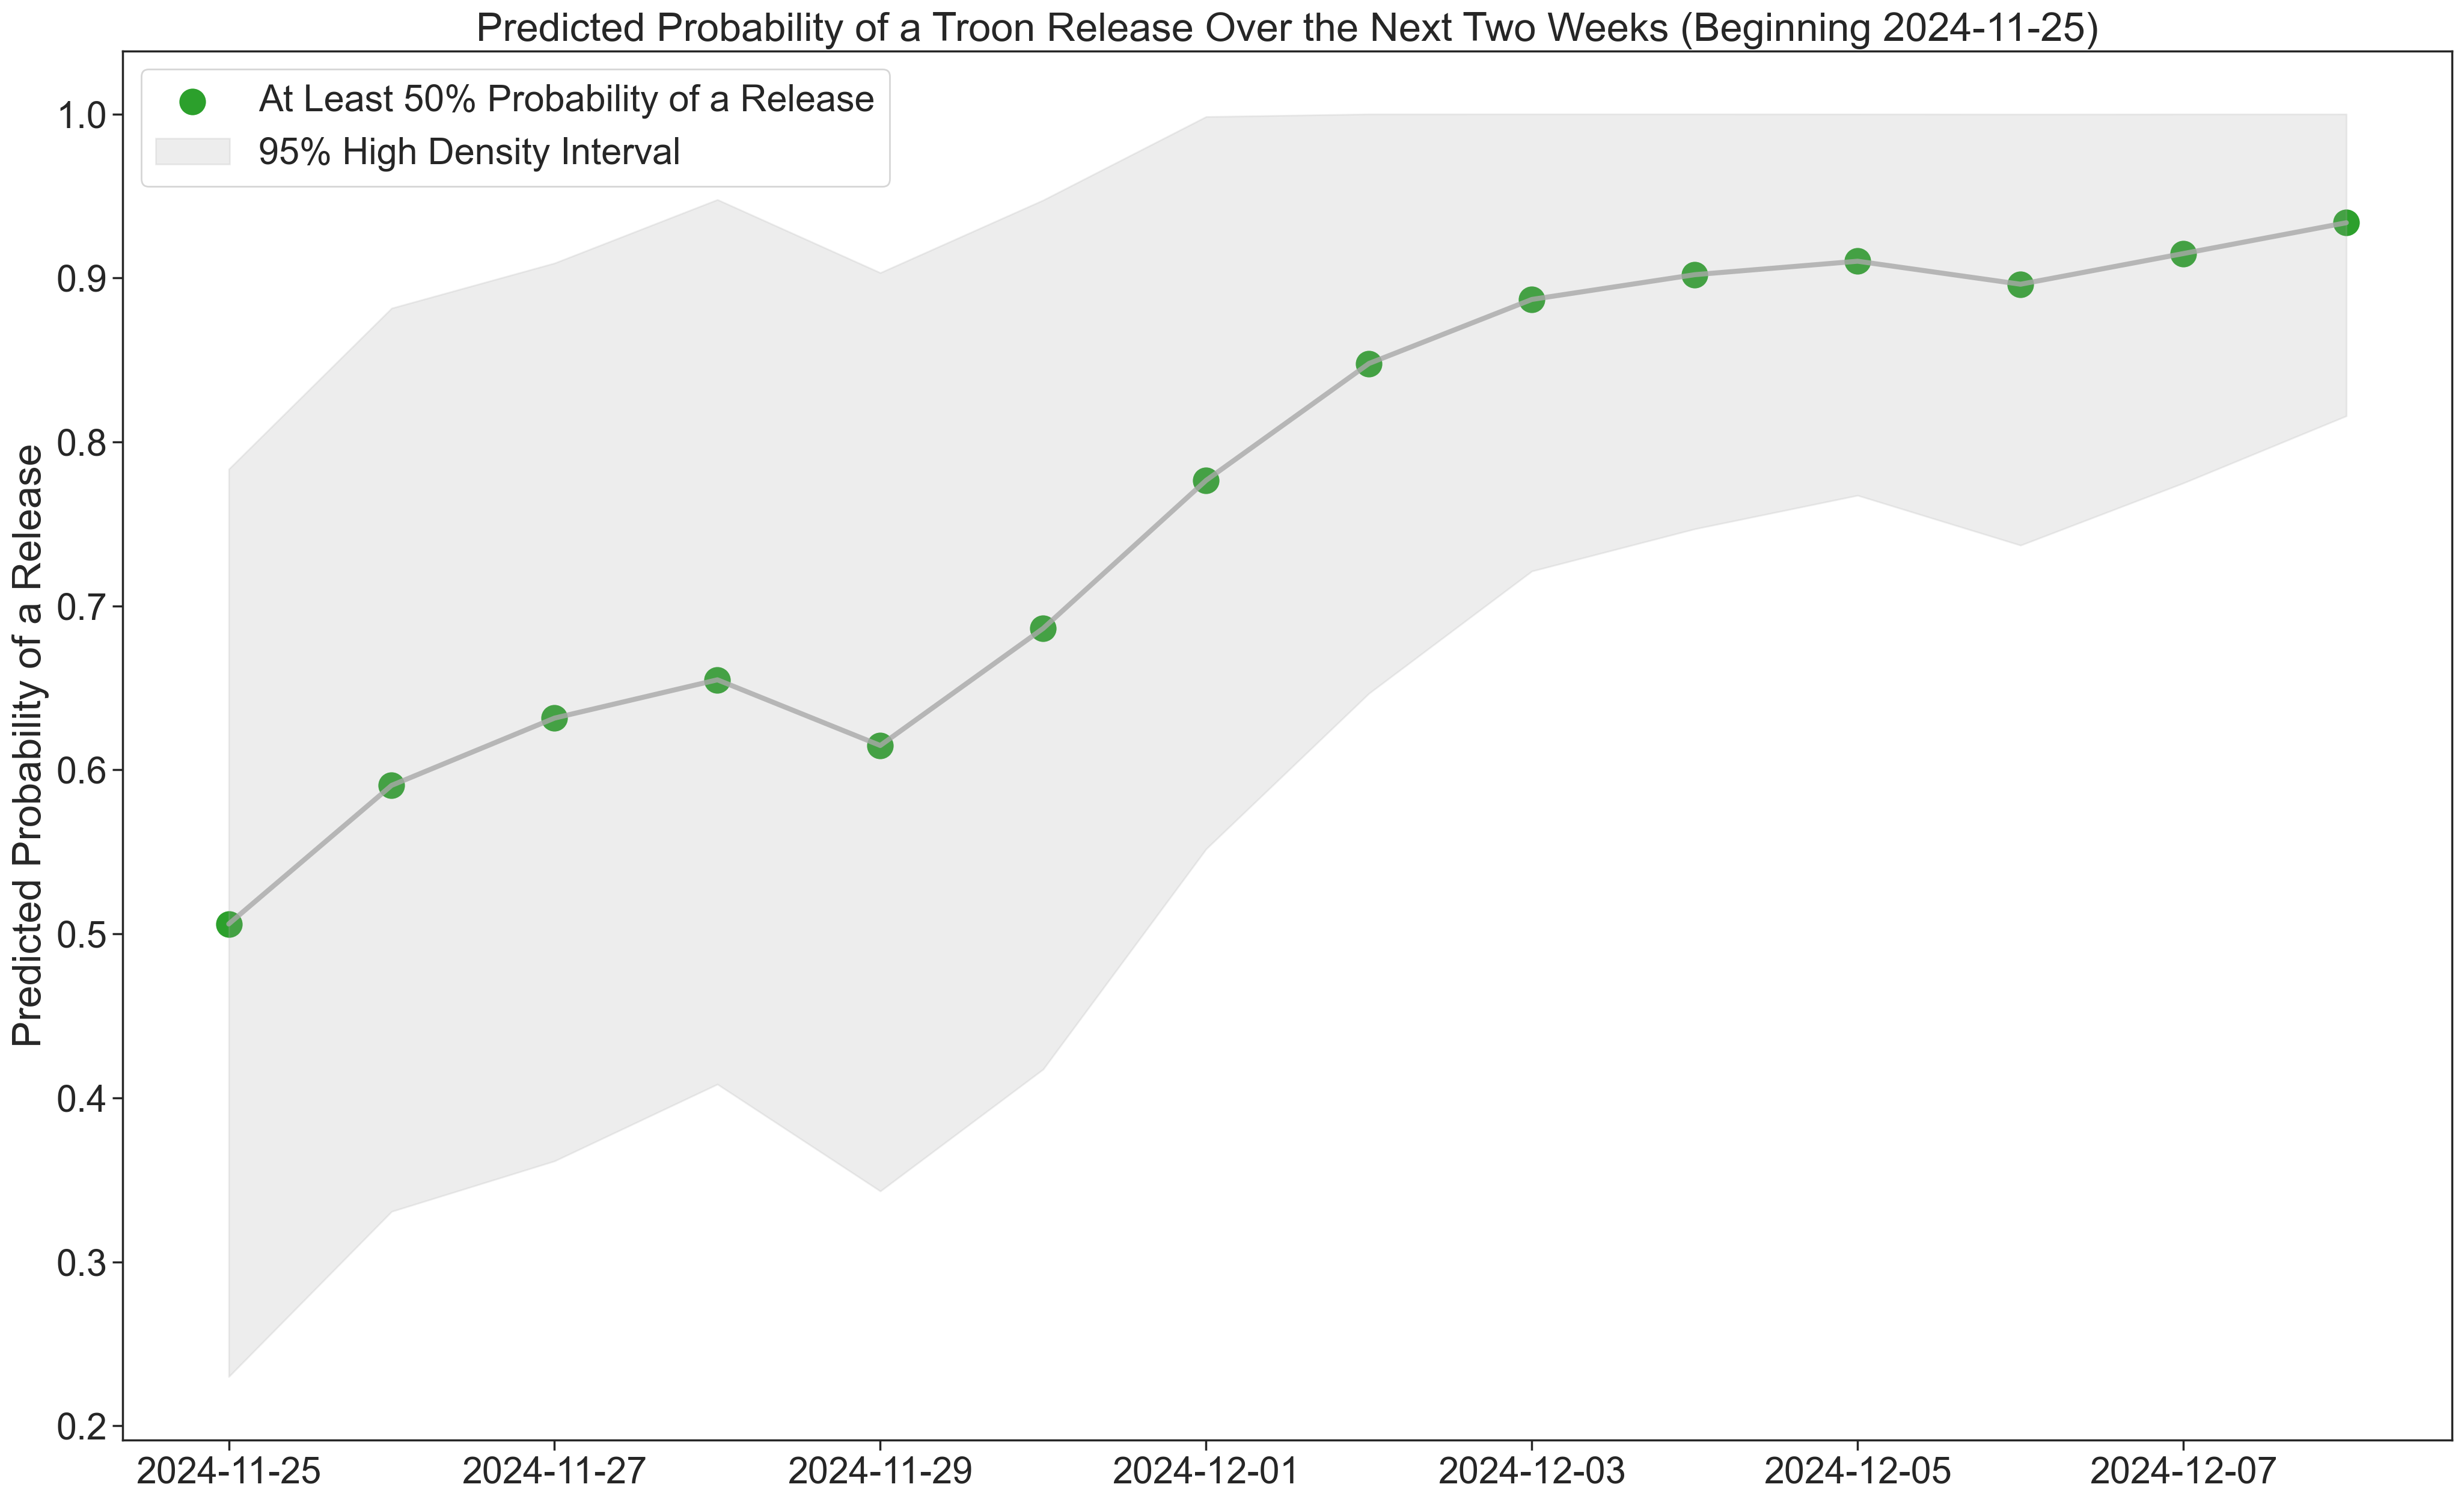

In [24]:
ax = sns.lineplot(data=next_two_weeks, x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_two_weeks[next_two_weeks["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_two_weeks["index"],
                y1=next_two_weeks["predicted_min"],
                y2=next_two_weeks["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_two_weeks["index"].iloc[0].date()))
ax.legend()
plt.show()